# Exploratory Text & Data Analysis 

By: Tiffany Aihara 

### Background 
Online dating has gained more popularity in recent years. Daters create a profile that is shared with people nearby with the hope of connecting with someone. Since dating profiles have texts and images, online daters struggle with “managing” their online presence (Ellison et al., 2006). During the initial stages, self-presentation strategies, “first impressions,” are significant in whether an interaction is considered “successful” (Derlega et al., 1987). Ellison et al. (2006) find the importance of portraying the ideal self in one’s profile. Most participants from their study had a recurrence of the “ideal self,” where participants created a profile that not only describes themselves today but also their potential and future version of themselves. More platforms also offer prompts or non-photo or visual features for users to include more of their “personality.” Regardless of the option, online daters make self-presentational choices, where they can choose what information to disclose, how to share it, and whether to engage in “deception” (Hancock & Toma 2009). Deception within the online dating community can be seen as exaggerated information that either emphasizes their status or physical attractiveness (Guadagno et a.l, 2012). Visual deception nowadays is less common than before, as many platforms have verification methods. 

### Interest to Research Question
My initial interest was to explore whether online daters choose authenticity or attractiveness or how much of each aspect was considered in the profile-development stage (self-presentation). From this initial interest, I developed the following questions: How do people view profiles in the online dating community? What is the "advice” given? In the spectrum between authenticity and attractiveness, where does "this" advice lie? Does it reveal any cultural or societal norms? Or any possible changes? 

Research Aim: To identify whether online dating advice (from the dating pool) reflects authenticity (personality, unedited/filtered) or attractiveness.

Research Question(s): What types of "advice" do daters receive from a public profile review? Is there a common trend? How is attractiveness used (ex. physical or non-physical attributes)? 

In [1]:
#Reddit-related libraries 
import praw
import reddit_info 

#Cleaning, Filtering, Text Analysis 
import pandas as pd
from string import punctuation 
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import re
import string
from collections import Counter
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import numpy as np 
from nltk.stem import WordNetLemmatizer

#Visualization 
from matplotlib import pyplot as plt

#Gensim (LDA)
import gensim 
import gensim.corpora as corpora 
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

### Gathering Data Using a Reddit API 
The following analysis uses data from Reddit’s subgroup “Hinge Dating App.” Hinge is a dating platform created in 2012, and within the page, users can ask others in the community to provide feedback on their profile. The program only extracts data from discussion threads tagged with a review. The discussion text was cleaned and used for further analysis. 

In [2]:
reddit = praw.Reddit(user_agent='Online Dating Profile', 
                    client_id = reddit_info.reddit_id, client_secret = reddit_info.secret, 
                    username = reddit_info.username, password = reddit_info.password)

Version 7.5.0 of praw is outdated. Version 7.6.0 was released Tuesday May 10, 2022.


In [3]:
subreddit =  reddit.subreddit('hingeapp')
submissions = subreddit.top(limit=100)

In [4]:
profile_reviews = {'id': [], 'title': [], 'link': [], 'date': []}

for submission in subreddit.search('flair:"Profile Review"', syntax='lucene'):
    profile_reviews['id'].append(submission.id) 
    profile_reviews['title'].append(submission.title)
    profile_reviews['link'].append(submission.permalink)
    profile_reviews['date'].append(submission.created_utc)

In [5]:
result = [] 
for each_id in profile_reviews['id']: 
    for each_comment in reddit.submission(each_id).comments[1:]: 
        result.append(each_comment.body)

### Cleaning Data

In [6]:
def remove_punctuation(word): 
    #Removes punctuation & returns just the word 
    word = word.lower() 
    new_word = word.translate(str.maketrans('', '', string.punctuation))
    return new_word

In [7]:
sample = [remove_punctuation(x) for x in result]
stop_words = set(stopwords.words('english'))

cleaned_data = [word.replace('\n', ' ') for word in sample] 
corpus = '' 

for each_sentence in cleaned_data: 
    corpus += each_sentence + ' '

In [8]:
cleaned_data[:5] #first five items of the cleaned data (visually see what this looks like)

['swap last photo with first photo',
 'i don’t think you’ve got enough clear shots of your face i wasn’t entirely sure what you really looked like',
 'youre cute and i would swipe right but i can see why many wont your prompts are a bit basic also im only 24 so i dont really know what men in their 30s are looking for  outside of the movie stuff it doesnt say much about you everybody likes food  a lot of people like the rain and the cold its just not that interesting  honestly it just seems like you have the profile of a typical girl in her mid 20s and i can see why older men wouldnt take a shot with you',
 'my love language is food come on you didn’t even try with that one  liking cold weather isn’t weird  some pics are a little far off and can’t really make out your face  but the good thing is you’re very attractive so it won’t even matter i almost think you posted this here just for validation',
 'all say if you want put bare minimum in those prompt don’t complain about quality of me

In [9]:
sample_token = word_tokenize(corpus)
clean_token = [word for word in sample_token if not word in stop_words]

### Adding & Graphing the Sentiment Score
Since the dataset went through one hundred Reddit discussion threads, I filtered only discussions (for the sentiment score) with the top three most occurred words. The dataframe shows what words, from the three most repeated words, the description, and the polarity score. 

In [10]:
word_appearance = {'word': [], 'count': []}
counter_data = [Counter(clean_token)]

for counter in counter_data: 
    for items in counter.items(): 
        word_appearance['word'].append(items[0])
        word_appearance['count'].append(items[1]) 
        

word_appearance['count'].sort(reverse = True)

In [11]:
top_three = word_appearance['count'][:3]

In [12]:
result_id = []
for i in range(len(top_three)):  
    result_id.append(word_appearance['count'].index(top_three[i]))

result_words = [] 
for i in range(len(result_id)): 
    result_words.append(word_appearance['word'][result_id[i]])
    
topthree_occur = {'Word': result_words, 'Count/Appearance': top_three}
search_words = topthree_occur['Word']

In [13]:
#Top Word Occurance (5)
search_words

['swap', 'last', 'photo']

In [14]:
def check_keyword(keywords: 'list of words', body: 'titletext'): 
    #Returns the keywords ONLY if it is in the title 
    body = body.lower() 
    result = '' 
    for every_word in keywords: 
        if every_word in body: 
            result += every_word + ', '
        else: 
            pass
    return result

In [15]:
topword_data_sample = {'Keyword': [], "Text": [], 'Polarity Score': []}
for each_comment in result: 
    if check_keyword(search_words, each_comment) != '': 
        topword_data_sample['Keyword'].append(check_keyword(search_words, each_comment)) 
        topword_data_sample['Text'].append(each_comment)
    else: 
        continue 

In [16]:
topword_data_sample['Text']

topword_text = [remove_punctuation(x) for x in topword_data_sample['Text']]
cleaned_topword = [word.replace('\n', ' ') for word in topword_text] 

def sentiment_analyze(text): 
    #text should be a cleaned text 
    score = SentimentIntensityAnalyzer().polarity_scores(text)
    neg = score['neg']
    pos = score['pos']
    if neg > pos: 
        topword_data_sample['Polarity Score'].append('Negative')
    elif pos > neg: 
        topword_data_sample['Polarity Score'].append("Positive")
    else: 
        topword_data_sample['Polarity Score'].append("Neutral")

In [17]:
for each_sentence in topword_data_sample['Text']: 
    sentiment_analyze(each_sentence)

    
df = pd.DataFrame(topword_data_sample) 

**Top 3 Phrases in Profile Reviews**: Closer Look

In [18]:
#A Dataframe to see the number of appearances a word appears in
pd.DataFrame(topthree_occur)

,Word,Count/Appearance
0,swap,2129
1,last,1004
2,photo,772


In [19]:
df.head(5)
#df.to_csv('hingeapp_advice.csv')

,Keyword,Text,Polarity Score
0,"swap, last, photo,",Swap last photo with first photo,Neutral
1,"photo,",I think you need more clear photos of your fac...,Positive
2,"photo,",This is an easy one: Your photos are fine but ...,Positive
3,"photo,",Regarding the profile - I definitely agree tha...,Positive
4,"swap, last,",You look good sure but none of your prompts he...,Positive


In [20]:
df['Polarity Score'].value_counts() 

Positive    442
Negative     51
Neutral      21
Name: Polarity Score, dtype: int64

Text(0.5, 1.0, 'Polarity Score of the Top Three Words in Hinge Profile Reviews')

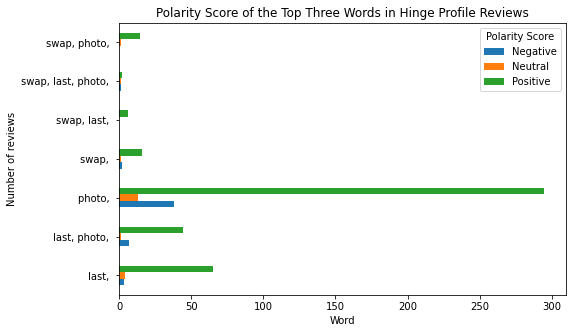

In [21]:
word_pol_score = df.get(['Keyword', 'Polarity Score'])
word_pol_score.value_counts().unstack().plot(kind='barh', figsize=(8, 5))

plt.xlabel('Word')
plt.ylabel('Number of reviews')
plt.title('Polarity Score of the Top Three Words in Hinge Profile Reviews')

### Explore the Reviews Further w/ Topic Modeling
This section will analyze all the subreddit comments and identify topics from the reviews that specifically mention a person's photo(s). The first few rows of code clean the data further by removing punctuating and duplicate words. The second part of the code constructs the LDA model. 

In [22]:
photo = [each_sent for each_sent in df[df['Keyword'] == 'photo, ']['Text']]

In [23]:
def to_list(sentence): 
  #Returns the sentence (str) into a list of words
  return sentence.split(' ') 

stopwords = [stopwords.words('english')]

In [24]:
lemmatizer = WordNetLemmatizer()
cleaned_content = [remove_punctuation(x) for x in photo] 
#clean_token = all reviews; 
#only the top word dataframe (w/ the sentiment) topword_data_sample['Text']]

clean_content_2 = []
for i in range(len(cleaned_content)): 
  clean_content_2.append(to_list(cleaned_content[i]))

clean_content_3 = []
for a_list in stopwords: 
  for each_sent in clean_content_2: 
    for each_word in each_sent: 
      if each_word in a_list: 
        pass
      else: 
        clean_content_3.append(each_word)

In [25]:
lemmatize_content = [lemmatizer.lemmatize(word) for word in clean_content_3]    
def gen_word(text): 
  final = [] 
  for each_text in text: 
    new = gensim.utils.simple_preprocess(each_text) #creating a token from the word 
    final.append(new)
  return final 

data_content = gen_word(lemmatize_content) 

In [26]:
id2word_content = corpora.Dictionary(data_content) #dictionary of word & token integer id 

content_corpus = [] 
description_corpus = [] 
for text in data_content: 
  new = id2word_content.doc2bow(text) 
  content_corpus.append(new)

#corpus is a tuple; #creating a bag of words and it's frequency (token)

In [34]:
lda_model_content = gensim.models.ldamodel.LdaModel(corpus=content_corpus, 
                                            id2word=id2word_content, 
                                            num_topics = 6, 
                                            random_state = 100, 
                                            update_every = 1, 
                                            chunksize=100, 
                                            passes = 10,
                                            alpha = 'auto')

### Visualizing the LDA Topic Modeling

In [48]:
from wordcloud import WordCloud, STOPWORDS

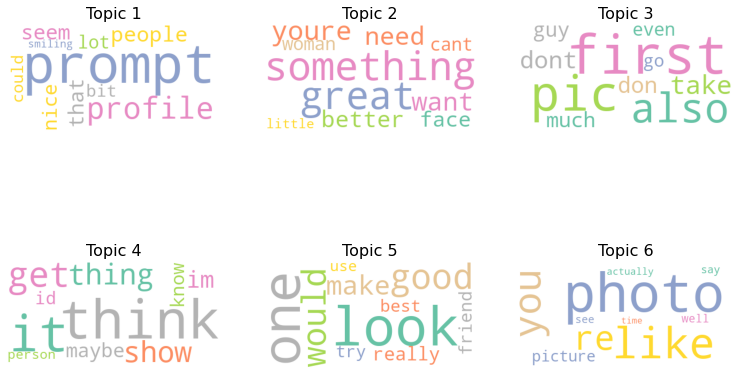

In [51]:
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  max_words=10, 
                 colormap='Set2')

topics = lda_model_content.show_topics(formatted=False)

fig, ax = plt.subplots(2, 3, figsize=(13,8))

for i, ax in enumerate(ax.flatten()): #counting the iteration, & not having to reiterate (loop) through each # of columns/rows
    fig.add_subplot(ax) #building the subplot
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=100) #generating the cloud
    plt.gca().imshow(cloud) 
    plt.gca().set_title('Topic ' + str(i + 1), fontdict=dict(size=16)) #topic header & font
    plt.gca().axis('off')

### Discussion & Reflection 
The sentiment analysis score showed that a majority, 448 out of 522, of reviews for a profile are generally positive. There were few neutral or negative reviews from the discussion containing the most frequent words. The sentiment analysis reveals how most reviews are positive or generally “good,” which could be community members providing constructive feedback and adhering to the community guidelines. One limitation of the sentiment analysis is that it may mistake sarcasm as a “positive” review. From the topic modeling, I used reviews with at least one mention of the word “photo.” The word cloud is the visualization of the topic model. The six topics show the different themes the reviews cover when looking at a dater’s pictures. The first topic reflects more on the authenticity of photos, insinuating the improvement of likes/matches associated with prompts and the profile itself. The second topic focus on the picture itself, “face,” and how it makes the individual “look,” whereas the third and fourth topic address neither. The last two topics seem to comment on how they present themselves in these photos and how others may perceive them. The topic model visualization provides a glimpse into how the online dating community advises others and what factors make individuals stand out to others. 

**ANALYSIS HERE -- still editing --**

This initial exploratory analysis explored the sentiment of advice and only filtered for words to classify advice that focused on attraction or authenticity. In this revised exploratory analysis, the topic model illustrated a new construct of “attraction to one’s authentic self,” where “attraction” towards physical attributes is not reflected as much in the dating community. In the future, I would explore tone and sarcasm within the sentiment analysis, create topic models on the sentiment score of the top ten words (only running the sentiment analysis on one word), or compare topic models on the advice given to prompts versus photos. 

### References
Derlega, V., Winstead, B., Wong, P., & Greenspan, M. (1987). Self-disclosure and relationship
development: An attributional analysis. In M. E. Roloff & G. R. Miller (Eds.), Interpersonal Processes: New Directions in Communication Research (pp. 172–187).Thousand Oaks, CA:Sage.

Ellison, Heino, R., & Gibbs, J. (2006). Managing Impressions Online: Self-Presentation Processes in the Online Dating Environment. Journal of Computer-Mediated Communication, 11(2), 415–441. https://doi.org/10.1111/j.1083-6101.2006.00020.

Guadagno, Okdie, B. M., & Kruse, S. A. (2012). Dating deception: Gender, online dating, and exaggerated self-presentation. Computers in Human Behavior, 28(2), 642–647. https://doi.org/10.1016/j.chb.2011.11.010. 

Hancock, & Toma, C. L. (2009). Putting Your Best Face Forward: The Accuracy of Online Dating Photographs. Journal of Communication, 59(2), 367–386. https://doi.org/10.1111/j.1460-2466.2009.01420.x